In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
%matplotlib inline

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
from utils_plot import plot_pics, plot_pics2
from utils_calibration import corners_unwarp, cal_undistort
from utils_threshold import color_channel
from utils_transform import perspec_trans, inverse_trans
from utils_lane import measure_curvature_real, fit_polynomial, search_around_poly, calc_deviation

In [4]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    vertices = np.array([[(150,718),(480,460),(810,460),(1150, 718)]],dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#     src = np.float32(
#         [[200, 718], 
#          [522, 500],
#          [769, 500],
#          [1100, 718]])

In [5]:
objpoints = [] # 3D points in real world spcae
imgpoints = [] # 2D points in image plans
nx = 9; ny = 6 

cal_images = glob.glob('./camera_cal/cali*.jpg')
for index, filename in enumerate(cal_images):
    warped_im, M = corners_unwarp(filename, nx, ny, objpoints, imgpoints)

None founded ./camera_cal\calibration01.jpg
./camera_cal\calibration02.jpg  complete
./camera_cal\calibration03.jpg  complete
None founded ./camera_cal\calibration04.jpg
None founded ./camera_cal\calibration05.jpg
./camera_cal\calibration06.jpg  complete
./camera_cal\calibration07.jpg  complete
./camera_cal\calibration08.jpg  complete
./camera_cal\calibration09.jpg  complete
./camera_cal\calibration10.jpg  complete
./camera_cal\calibration11.jpg  complete
./camera_cal\calibration12.jpg  complete
./camera_cal\calibration13.jpg  complete
./camera_cal\calibration14.jpg  complete
./camera_cal\calibration15.jpg  complete
./camera_cal\calibration16.jpg  complete
./camera_cal\calibration17.jpg  complete
./camera_cal\calibration18.jpg  complete
./camera_cal\calibration19.jpg  complete
./camera_cal\calibration20.jpg  complete


In [6]:
def image_pipeline(im0_test):
    # global initial, left_fit, right_fit
    
    im1_undist = cal_undistort(im0_test, objpoints, imgpoints)
    # im1_2_undist = region_of_interest(im1_undist)
    im2_colorChannel = color_channel(im1_undist)
    im3_perspecTrans = perspec_trans(im2_colorChannel)
    
    im4_firstfit, left_fit, right_fit = fit_polynomial(im3_perspecTrans)
    im5_effi, ploty = search_around_poly(im3_perspecTrans, left_fit, right_fit)
    
    
#     if initial == False:
#         im5_effi, ploty = search_around_poly(im3_perspecTrans, left_fit, right_fit)
#     elif initial == True:
#         im4_firstfit, left_fit, right_fit = fit_polynomial(im3_perspecTrans)
#         im5_effi, ploty = search_around_poly(im3_perspecTrans, left_fit, right_fit)
    
    curvature = measure_curvature_real(ploty, im3_perspecTrans)
    offset = calc_deviation(im3_perspecTrans, ploty, left_fit, right_fit)
    
    im6_inverse = inverse_trans(im5_effi)
    im7_final = cv2.addWeighted(im6_inverse, 2, im1_undist, 1, 0)

    
    h, w = im1_undist.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = im7_final.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(w, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    im = cv2.addWeighted(src1=mask, alpha=0.2, src2=im7_final, beta=0.8, gamma=0)

    # add thumbnail of binary image
    thumb_binary = cv2.resize(im2_colorChannel, dsize=(thumb_w, thumb_h))
    thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255
    im7_final[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary

    # add thumbnail of bird's eye view
    thumb_birdeye = cv2.resize(im3_perspecTrans, dsize=(thumb_w, thumb_h))
    thumb_birdeye = np.dstack([thumb_birdeye, thumb_birdeye, thumb_birdeye]) * 255
    im7_final[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_birdeye

    # add thumbnail of bird's eye view (lane-line highlighted)
    thumb_img_fit = cv2.resize(im5_effi, dsize=(thumb_w, thumb_h))
    im7_final[off_y:thumb_h+off_y, 3*off_x+2*thumb_w:3*(off_x+thumb_w), :] = thumb_img_fit

    # add text (curvature and offset info) on the upper right of the blend
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im7_final, 'Curvature radius: {:.02f}m'.format(curvature), (860, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(im7_final, 'Offset from center: {:.02f}m'.format(offset), (860, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    
    return im7_final

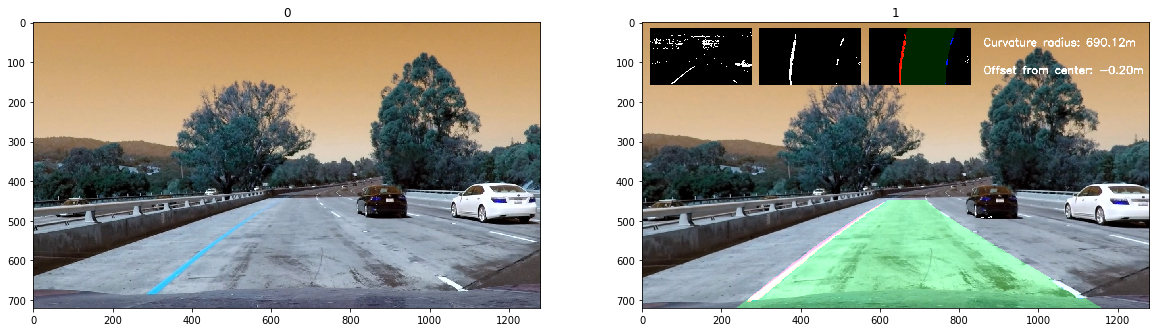

In [7]:
initial = True
road_images = glob.glob('./test_images/*.jpg')
test_filename = road_images[2]
im0_test = cv2.imread(test_filename)
processed_im = image_pipeline(im0_test)
plot_pics([im0_test, processed_im])

In [8]:
# initial = True
# left_fit = None; right_fit = None
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
Wall time: 16min 13s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))